# Downloading products from the XMM-Newton archive (NXSA)

The XMM-Newton Science Archive (NXSA) allows access to the content via [TAP queries](http://www.ivoa.net/documents/TAP/) and direct URL access to the products. 

In [72]:
import os
import tarfile
import requests
import pandas as pd
from io import StringIO

from astropy.io import fits
#import numpy as np

import matplotlib.pylab as plt
from matplotlib.ticker import FormatStrFormatter

## TAP query example

The TAP needs to access 3 tables: 

1. `v_public_observations`: a table with all currently public XMM-Newton oservations.
2. `v_exposure`: a table with additional information about each observation and exposure, this is needed if we want to search for particular observing modes, which are not available in the `v_public_observations` table.
3. `v_instrument_mode`: this table provides the mapping of the numeric `instrument_mode_oid` to its human readable name `mode_friendly_name`. 

In the following example we query the NXSA for all public observations with:

* minimum duration of `min_expo`, note that this is the planned duration and not the good-time-interval filtered exposure. 
* all EPIC-pn observing modes, these are those with `observing_oid` between 60 and 69.

The table returned by the query is then converted to `pandas` dataframe and further filtered to contain only observations performed with `THIN`, `MEDIUM` or `THICK` filter. Therefore the dataframe `out_df` will contain the final selection.

In [59]:
#
# the TAP access
#
tap_url = "http://nxsa.esac.esa.int/tap-server/tap/sync?REQUEST=doQuery&LANG=ADQL&FORMAT=csv&"
#
# the ADQL query
#
min_expo = 20000 # duration at least 20 ks
query = f"QUERY=select t2.observation_id,t2.ra,t2.dec,t2.revolution,t2.duration,t3.mode_friendly_name,t1.filter" + \
" from v_exposure as t1, v_public_observations as t2, v_instrument_mode as t3" + \
" WHERE " + \
f"(t1.duration >= {min_expo}) and " + \
"(t1.observation_oid = t2.observation_oid) and " + \
"(t1.instrument_mode_oid BETWEEN 60 and 69) and " + \
"(t1.instrument_mode_oid = t3.instrument_mode_oid)"
#
xreq = tap_url + query
# send GET request via AIO 
with requests.get(xreq) as r:
    jx = r.content.decode()
#
if ('ERROR' in jx):
    print ("ADQL query returns error:",jx)
    raise Exception
buff = StringIO(jx)
df = pd.read_csv(buff, sep=",")
#
# rename some columns
#
df.rename(columns={'observation_id': 'obs_id','mode_friendly_name': 'obs_mode',\
                   'revolution': 'rev'},inplace=True)
#
# now select those with 'MEDIUM', 'THICK', 'THIN2', 'THIN1'
# wil use pandas quesry function.
#
df['filter'] = df['filter'].str.upper()
#
out_df = df.query("filter in [\"THIN1\",\"THIN2\",\"THICK\",\"MEDIUM\"]")

In [60]:
out_df[0:10]
#print (f"Selected {len(out_df)} XMM-Newton EPIC-pn public observations.")


,obs_id,ra,dec,rev,duration,obs_mode,filter
0,110101,64.925415,55.999440,310,32913,Full Frame,MEDIUM
1,1930101,6.529166,10.689170,200,26609,Full Frame,THIN1
2,1930301,193.500000,10.186390,376,25192,Full Frame,THIN1
3,2740501,166.970400,-77.615550,427,33986,Full Frame,THIN1
4,4010201,31.407090,64.828330,221,23610,Small Window,THIN1
5,4610301,275.408700,68.464450,541,23916,Extended Full Frame,THIN1
6,5010101,220.530900,35.439720,561,27751,Small Window,MEDIUM
7,5010201,220.530900,35.439720,562,29435,Small Window,MEDIUM
8,5010301,220.530900,35.439720,564,26453,Small Window,MEDIUM
9,5210101,175.815375,20.055833,358,33463,Extended Full Frame,MEDIUM


## Download an XMM spectrum

Once we have the list of observation IDs we can directly access the different products linked to it: the low-level ODFs, the pipeline products PPS, the images and/or the spectra.

In this example we are only interested of the spectral products for the brightest source in the observation. By convention, the spectral products are numbered from 1 to the number of detected sources, starting from the brightest one.

The access to the products is through an URL, constructed with the observation id and the type of the product. In this example, the spectral pipeline products (`level=PPS`) are under `name=SRSPEC`, the file extension is `FTZ` (i.e. zipped FITS file) and we only restrict to files with EPIC-pn, `instname=PN`.

More information on the available pipeline products and their content is available in the [Specifications for individual SSC data products](ftp://xmm2.esac.esa.int/pub/odf/data/docs/XMM-SOC-GEN-ICD-0024.pdf) document. The `SRSPEC` product is described in section 6.5.4.2 (on page 54).

We cannot select only one `SRSPEC`, so all spectra from the same observation will be added to a TAR file. This makes the task a bit complicated, because if there is only one spectrum in the observation then the returned files will be `FTZ` and not `TAR`.

The `TAR` file has to be downloaded and we set a temporary folder `tmdir`. After extraction of the spectrum the `TAR` file can be deleted.

Now we have the `TAR` file or the `FTZ` one if there is only one source, but in both cases the saved filename is `tarFile`, so we have to check if the file is indeed `TAR` before we start extracting the spectrum of the brightest source (`src_index=1`).

We introduce a further filtering based on exposure after the good-time-interval (GTI) filtering by the pipeline, setting the minimum exposure to `expo_limit`.

These are all implemented in the utility function `get_xmm_spectrum()`.

In [61]:
#
# select a random obsid from the TAP results
#
# the obs_id is a 10 character string
obs_id = "{:010}".format(out_df.sample(n=1).obs_id.iloc[0])

In [62]:
def get_xmm_spectrum(instrument="PN",product="SRSPEC", src_index=1, expo_limit=15.0, \
                     outputFile=None, tmpdir='./'):
    #
    # if output is None then the spectrum will not be saved but the HDU will be returned
    #
    extn = "FTZ"
    #
    url = 'http://nxsa.esac.esa.int/nxsa-sl/servlet'
    req  = f"{url}/data-action-aio?obsno={obs_id}&extension={extn}&name={product}&instname={instrument}&level=PPS"
    #
    tarFile = f"{tmpdir}/pps_spec.tar"
    print (f"Downloading tar file for {obs_id} from NXSA... wait")
    with requests.get(req) as r:
        if (b'No results' in r.content):
            print (f"No PPS spectral products found for {obs_id}")
            return None
        else:
            with open(tarFile,"wb") as tmp:
                tmp.write(r.content)
    print (f"{inst} spectra saved to {tarFile}")
    # 
    # Extract the spectrum
    #
    hdu = None
    try:
        with tarfile.open(tarFile,'r') as tar:
            src = f'{product}{src_index:04}'
            for member in tar.getmembers():
                if (src in member.name):
                    print (f"Extracting {member.name}")
                    f=tar.extract(member,path=tmpdir)
                    hdu = fits.open(f"{tmpdir}/{member.name}")
                    texp = hdu[1].header['EXPOSURE']/1000.0
                    if (texp >= expo_limit):
                        if (outputFile != None):
                            hdu.writeto(outputFile,overwrite=True)
                            print (f"Saved PN {product} 01 for {obs_id}, the total exposure after GTI is {texp:.1f} ks (>= {expo_limit} ks)")                        
                            return hdu
                    else:
                        print (f"Will skip PN {product} 01 for {obs_id} as the total exposure after GTI is {texp:.1f} ks (< {expo_limit} ks)")
                        return None
                    break
    except:
        # only one file and it's FTZ file
        hdu = fits.open(tarFile)
        texp = hdu[1].header['EXPOSURE']/1000.0
        if (texp >= expo_limit):
            if (outputFile != None):
                hdu.writeto(outputFile,overwrite=True)
                print (f"Saved PN {product} 01 for {obs_id}, the total exposure after GTI is {texp:.1f} ks (>= {expo_limit} ks)")
                return hdu
        else:
            print (f"Will skip PN {product} 01 for {obs_id} as the total exposure after GTI is {texp:.1f} ks (< {expo_limit} ks)")
            return None
    return hdu

The function `get_xmm_spectrum()` can be used to download a source spectrum (`product=SRSPEC`) but also to download the background spectrum (`product=BGSPEC`). This is shown in the following example. 

In [63]:
#
# set some variables and extract a spectrum
#
tmpdir = os.path.expanduser('~') + '/Tmp/XMM_data'
ftype = "SRSPEC"
oFile = f"{tmpdir}/{obs_id}_spectrum_{src_index:04}.fits.gz"
#
hdu = get_xmm_spectrum(instrument="PN",product=ftype, src_index=1, expo_limit=15.0, \
                     outputFile=oFile, tmpdir=tmpdir)

PN spectra saved to /Users/ivaltcha/Tmp/XMM_data/pps_spec.tar
Extracting 0724840301/pps/P0724840301PNS003SRSPEC0001.FTZ
Saved PN SRSPEC 01 for 0724840301, the total exposure after GTI is 38.6 ks (>= 15.0 ks)


In [64]:
#
# we can also extract the background file
#
ftype = "BGSPEC"
bkgFile = f"{tmpdir}/{obs_id}_bkg_{src_index:04}.fits.gz"
#
bkg_hdu = get_xmm_spectrum(instrument="PN",product=ftype, src_index=1, expo_limit=15.0, \
                     outputFile=bkgFile, tmpdir=tmpdir)


PN spectra saved to /Users/ivaltcha/Tmp/XMM_data/pps_spec.tar
Extracting 0724840301/pps/P0724840301PNS003BGSPEC0001.FTZ
Saved PN BGSPEC 01 for 0724840301, the total exposure after GTI is 38.6 ks (>= 15.0 ks)


Now we visualise the spectrum and the background:

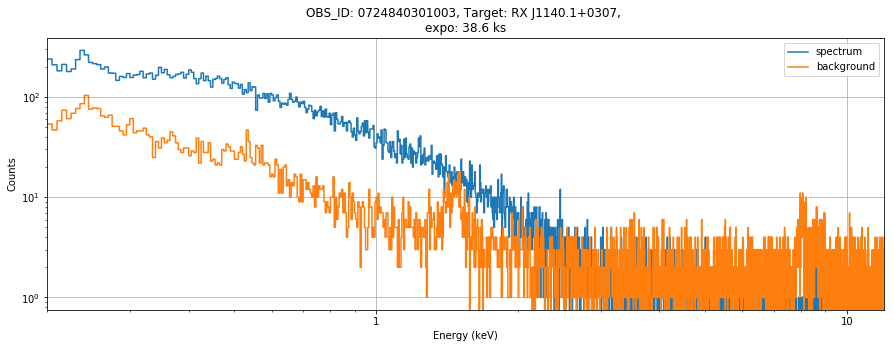

In [73]:
#
# will reuse the already opened HDU
# or we can read the saved FITS spectrum
#hdu = fits.open(outputFile)
#
plot_title = f"OBS_ID: {hdu[0].header['EXP_ID']}, " + \
    f"Target: {hdu[0].header['OBJECT']}, \n" + \
    f"expo: {hdu['SPECTRUM'].header['EXPOSURE']/1000.0:.1f} ks"
#
spec = hdu['SPECTRUM']
binsize = spec.header['SPECDELT']
x = spec.data['CHANNEL']*binsize/1000.0
y = spec.data['COUNTS']
#
bgspec = bkg_hdu['SPECTRUM']
binsize = bgspec.header['SPECDELT']
xbg = bgspec.data['CHANNEL']*binsize/1000.0
ybg = bgspec.data['COUNTS']

xlims  = (0.2, 12.0)
#
fig = plt.figure(figsize=(15,5))
ax = fig.subplots()
ax.step(x,y,label='spectrum')
ax.step(xbg,ybg,label='background')
#ax.step(x,y,color='red')
ax.set_xlim(xlims)
ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")
ax.set_title(plot_title)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(FormatStrFormatter("%g"))
ax.legend()
ax.grid()